# **Customer Spending Prediction using XGBoost**

<!-- #### **Definition**

Customer Lifetime Value (CLV) is a metric that quantifies the total value a customer brings to a business over the entire duration of their relationship. It's an estimation of the net profit a company can expect to generate from a customer during their engagement with the business.

CLV takes into account not only the initial purchase value but also subsequent purchases, repeat transactions, and customer retention. It considers the revenue generated by the customer and deducts the associated costs with acquiring, serving, and retaining them. CLV provides insights into the long-term profitability and value of each customer.

By calculating CLV, business can identify high-value customers, tailor marketing strategies to retain them, allocate resources effectively, and make informed business decisions regarding customer acquisition and retention efforts. CLV is essential for understanding the return on investment of acquiring and maintaining customers, helping businesses focus on activities that maximize CLV and overall profitability. -->


<!-- #### **Project Goal**

The goal of this project is to develop a prediction model that can accurately forecast customer spend in the next 90 days based on their historical transaction data. By leveraging feature engineeing techniques and the XGBoost model, we aim to provide insights into future customer spending patterns, enabling businesses to make data-driven decision regarding resource allocation, marketing strategies, and customer retention efforts. The ultimate objective is to maximize customer lifetime value, enhance profitability, and drive business growth by accurately predicting and understanding customer spend behavior in the short term. -->

<!-- #### **Steps**

* Data Prep
    - Clean and preprocess the historical transaction data, checking for missing values and inconsistencies
    - Format the transaction date column into a datetime format 
    
* Feature Engineering
    - Create time-based features, such as recency, frequency, and monetary features
    - Recency: the number of days between the latest transaction date and the prediction date for each customer
    - Frequency: the total number of purchases made by each customer over the historical data period
    - Monetary: the total value of purchases made by each customer over the historical data period
    - Extra features: e.g., average purchase value, standard deviation of purchase value, or average time between purchases
    - Set the target variable as the customer spend in the latest 90 days: from max(transaction date) - 90 days to max(transaction date)
    - Set the independent variables as: recency, frequency, monetary features (e.g., total value of purchases, average value of purchases) before the earliest prediction date 

* Model Training and Hyperparameters Tuning
    - Train/Test datasets splitting
    - Train an XGBoost regression model on the training dataset
    - Run cross-validation and hyperparameter tuning (GridSearch CV or RandomizedSearch CV) to optimize the model's performance

* Model Evaluation
    - Evaluate the trained model using appropriate evaluation metrics such as RMSE, MSE, or R-squared
    - Test the trained model's power on unseen data

* Feature Importance Analysis
    - Analyze the feature importance provided by the XGBoost model to understand which features contribute the most to the prediction

* Predict Customer Spend
    - Utilize the trained XGBoost model to predict customer spend for the next 90 days using the feature-engineered input data -->


### Data Preparation

* Data transformation
* Checking missing values

In [31]:
# read data
import pandas as pd

df = pd.read_csv("data/sample_data.csv")
df.head()

,customer_id,transaction_date,num_of_purchase,value_of_purchase
0,1,1997-01-01,1.0,11.77
1,2,1997-01-12,1.0,12.00
2,2,1997-01-12,5.0,77.00
3,3,1997-01-02,2.0,20.76
4,3,1997-03-30,2.0,20.76


In [32]:
# convert transaction date into datetime format
df["transaction_date"] = pd.to_datetime(df["transaction_date"])

# convert num_of_purchse and value_of_purchase to numerics
df["num_of_purchase"] = pd.to_numeric(df["num_of_purchase"])
df["value_of_purchase"] = pd.to_numeric(df["value_of_purchase"])

# drop missing values
df = df.dropna()

In [33]:
df.describe()

,customer_id,transaction_date,num_of_purchase,value_of_purchase
count,68549.000000,68549,68549.000000,68549.000000
mean,11466.363375,1997-07-02 10:51:07.738406144,2.270496,33.267407
min,1.000000,1997-01-01 00:00:00,1.000000,0.000000
25%,5499.000000,1997-02-22 00:00:00,1.000000,14.420000
50%,11404.000000,1997-04-23 00:00:00,2.000000,25.740000
75%,17266.000000,1997-11-07 00:00:00,3.000000,42.690000
max,23570.000000,1998-06-30 00:00:00,1286.010000,1286.010000
std,6818.514070,NaN,7.761612,27.727437


### EDA

* Variation of total purchase value by time & Variation of total purchase frequency by time
* Customer segmentation by total purchase value & Customer segmentation by total purchase frequency

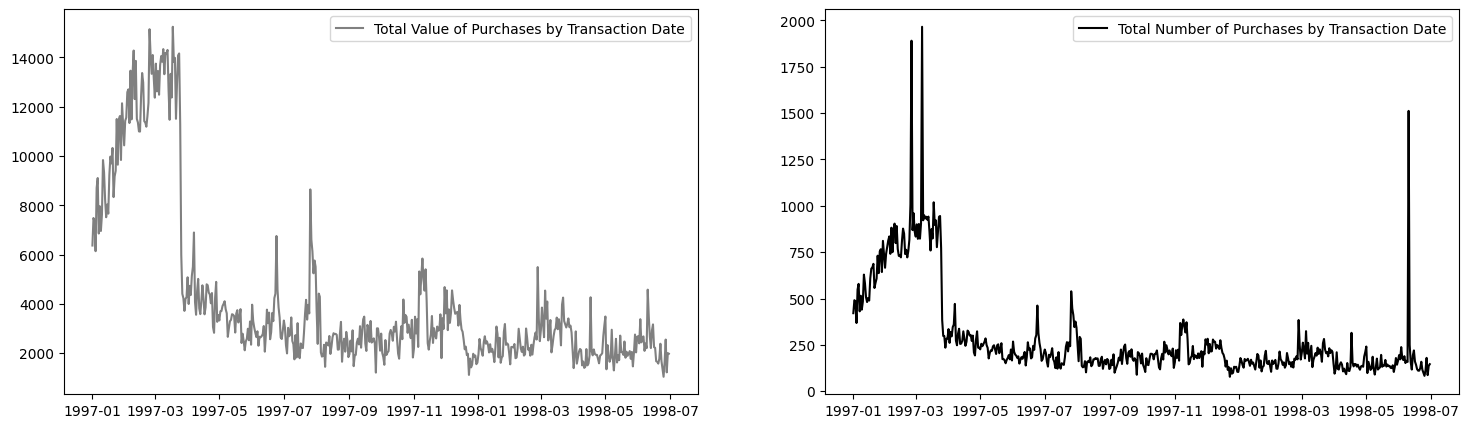

In [34]:
# total value of purchases by transaction date
total_value_by_date = df.groupby("transaction_date")[["value_of_purchase"]].sum()

# total number of purchases by transaction date
total_numofpurchase_by_date = df.groupby("transaction_date")[["num_of_purchase"]].sum()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# plot data
g1 = sns.lineplot(data=total_value_by_date, x="transaction_date", y="value_of_purchase", color="gray", ax=ax[0])
g1.legend(labels=["Total Value of Purchases by Transaction Date"])
g1.set(ylabel=None)
g1.set(xlabel=None)

g2 = sns.lineplot(data=total_numofpurchase_by_date, x="transaction_date", y="num_of_purchase", color="black", ax=ax[1])
g2.legend(labels=["Total Number of Purchases by Transaction Date"])
g2.set(ylabel=None)
g2.set(xlabel=None)

plt.show()

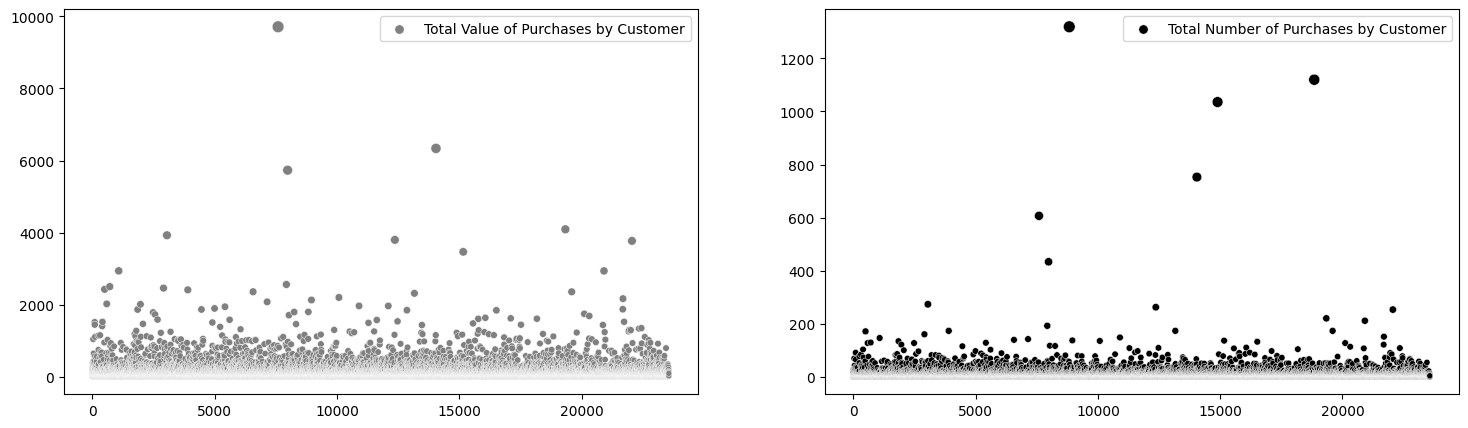

In [35]:
total_value_by_customer = df.groupby("customer_id")["value_of_purchase"].sum().reset_index()
total_frequency_by_customer = df.groupby("customer_id")["num_of_purchase"].sum().reset_index()

import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# plot data
g1 = sns.scatterplot(data=total_value_by_customer, x="customer_id", y="value_of_purchase", color="gray", ax=ax[0], size="value_of_purchase")
g1.legend(labels=["Total Value of Purchases by Customer"])
g1.set(ylabel=None)
g1.set(xlabel=None)

g2 = sns.scatterplot(data=total_frequency_by_customer, x="customer_id", y="num_of_purchase", color="black", ax=ax[1], size="num_of_purchase")
g2.legend(labels=["Total Number of Purchases by Customer"])
g2.set(ylabel=None)
g2.set(xlabel=None)

plt.show()

### Feature Engineering: Getting RFM for Each Customer

* Separate data into historical data vs. prediction period
* Calculate RFM for each customer

In [36]:
from datetime import timedelta

earliest_prediction_date = max(df["transaction_date"]) - timedelta(days=90)
earliest_prediction_date

Timestamp('1998-04-01 00:00:00')

In [37]:
# only keep customers that have records before `earliest_prediction_date`
historical_df = df[df["transaction_date"] < earliest_prediction_date]
historical_df

,customer_id,transaction_date,num_of_purchase,value_of_purchase
0,1,1997-01-01,1.0,11.77
1,2,1997-01-12,1.0,12.00
2,2,1997-01-12,5.0,77.00
3,3,1997-01-02,2.0,20.76
4,3,1997-03-30,2.0,20.76
...,...,...,...,...
68544,23568,1997-04-05,4.0,83.74
68545,23568,1997-04-22,1.0,14.99
68546,23569,1997-03-25,2.0,25.74
68547,23570,1997-03-25,3.0,51.12


In [38]:
# calculate recency
historical_df["date_diff"] = historical_df[["transaction_date"]] - earliest_prediction_date
input_df = historical_df.loc[historical_df.groupby('customer_id')['date_diff'].idxmax()][["customer_id", "date_diff"]]
input_df = input_df.rename(columns={"date_diff": "recency"})
input_df

/var/folders/6d/_yrgtwy55rj1cyx070_1vq8w0000gp/T/ipykernel_34820/2436305498.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historical_df["date_diff"] = historical_df[["transaction_date"]] - earliest_prediction_date


,customer_id,recency
0,1,-455 days
1,2,-444 days
7,3,-127 days
12,4,-110 days
23,5,-88 days
...,...,...
68541,23566,-372 days
68542,23567,-372 days
68545,23568,-344 days
68546,23569,-372 days


In [39]:
# calculate frequency
input_df = pd.merge(input_df, historical_df.groupby("customer_id")["num_of_purchase"].sum().reset_index(), on='customer_id')
input_df = input_df.rename(columns={"num_of_purchase": "frequency"})
input_df

,customer_id,recency,frequency
0,1,-455 days,1.0
1,2,-444 days,6.0
2,3,-127 days,15.0
3,4,-110 days,7.0
4,5,-88 days,29.0
...,...,...,...
23440,23566,-372 days,2.0
23441,23567,-372 days,1.0
23442,23568,-344 days,6.0
23443,23569,-372 days,2.0


In [40]:
# monetary feature: calculate the total value of purchase for each customer
total_value_by_customer = total_value_by_customer.rename(columns={"value_of_purchase": "total_purchase_value"})
input_df = pd.merge(input_df, total_value_by_customer, on='customer_id')
input_df

,customer_id,recency,frequency,total_purchase_value
0,1,-455 days,1.0,11.77
1,2,-444 days,6.0,89.00
2,3,-127 days,15.0,156.46
3,4,-110 days,7.0,100.50
4,5,-88 days,29.0,385.61
...,...,...,...,...
23440,23566,-372 days,2.0,36.00
23441,23567,-372 days,1.0,20.97
23442,23568,-344 days,6.0,121.70
23443,23569,-372 days,2.0,25.74


In [41]:
# remove strings from recency
recencies = []
for i in range(len(input_df["recency"])):
    recencies.append(input_df.loc[i]["recency"].days)

input_df["recency"] = recencies
input_df

,customer_id,recency,frequency,total_purchase_value
0,1,-455,1.0,11.77
1,2,-444,6.0,89.00
2,3,-127,15.0,156.46
3,4,-110,7.0,100.50
4,5,-88,29.0,385.61
...,...,...,...,...
23440,23566,-372,2.0,36.00
23441,23567,-372,1.0,20.97
23442,23568,-344,6.0,121.70
23443,23569,-372,2.0,25.74


In [42]:
# calculate the spend in the next 90 days for each customer, if customer does not have records after earliest prediction date, then we set the spend_90_day as 0
prediction_df = df[df["transaction_date"] >= earliest_prediction_date].groupby("customer_id")["value_of_purchase"].sum().reset_index()

spend_90_day = []
for id in input_df["customer_id"].values:
    if id in prediction_df["customer_id"].values:
        spend_90_day.append([id, prediction_df[prediction_df["customer_id"]==id]["value_of_purchase"].values[0]])
    else:
        spend_90_day.append([id, 0])

output_df = pd.DataFrame(spend_90_day, columns=["customer_id", "spend_90_day"])
output_df

,customer_id,spend_90_day
0,1,0.00
1,2,0.00
2,3,16.99
3,4,0.00
4,5,0.00
...,...,...
23440,23566,0.00
23441,23567,0.00
23442,23568,0.00
23443,23569,0.00


### Model Training & Hyperparameter Tuning

* Split dataset into train/test sets
* Load data into DMatrices
* Build a baseline
* Model training with default config
* Fine-tuning with `xgboost.cv`

In [13]:
# data
data = pd.merge(input_df, output_df, on="customer_id")

# split the data
from sklearn.model_selection import train_test_split

X, y = data.drop(columns=["customer_id", "spend_90_day"]), data[["spend_90_day"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

In [14]:
# load data into DMatrices
import xgboost as xgb

dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

In [15]:
# build a baseline model 
from sklearn.metrics import mean_squared_error
import numpy as np

# get predictions on the test set
mean_train = np.mean(y_train)
baseline_predictions = np.ones(y_test.shape) * mean_train

# compute rmse
rmse_baseline = mean_squared_error(y_test, baseline_predictions, squared=False)

print("Baseline RMSE is {:.2f}".format(rmse_baseline))

Baseline RMSE is 32.22


In [16]:
# model training with default config

# default config
params = {
    "max_depth": 6,
    "min_child_weight": 1,
    "eta": 0.3,
    "subsample": 1,
    "colsample_bytree": 1,
    "objective": "reg:squarederror",
    "eval_metric": "rmse",
}

num_boost_round = 999 # set number of boosting round as 999, and let early stopping technique decides where to stop

model = xgb.train(
    params,
    dtrain_reg,
    num_boost_round=num_boost_round,
    evals=[(dtest_reg, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:27.96674
[1]	Test-rmse:25.15509
[2]	Test-rmse:23.23015
[3]	Test-rmse:22.52315
[4]	Test-rmse:21.38583
[5]	Test-rmse:20.69144
[6]	Test-rmse:20.55333
[7]	Test-rmse:20.25883
[8]	Test-rmse:20.14081
[9]	Test-rmse:20.02882
[10]	Test-rmse:20.01673
[11]	Test-rmse:19.95667
[12]	Test-rmse:20.08958
[13]	Test-rmse:20.06875
[14]	Test-rmse:20.08339
[15]	Test-rmse:20.03260
[16]	Test-rmse:20.03230
[17]	Test-rmse:19.99002
[18]	Test-rmse:19.98232
[19]	Test-rmse:19.93058
[20]	Test-rmse:19.98696
[21]	Test-rmse:20.00055
[22]	Test-rmse:19.96286
[23]	Test-rmse:19.94905
[24]	Test-rmse:20.00112
[25]	Test-rmse:19.99092
[26]	Test-rmse:20.00368
[27]	Test-rmse:19.96424
[28]	Test-rmse:20.03781
[29]	Test-rmse:20.09745


In [17]:
# The RMSE of our model with default parameters and an optimal number of boosting rounds on the test set
print("Best MAE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best MAE: 19.93 with 20 rounds


Quick Understanding of Major Parameters:

|Parameter Category| Parameter Name|Meaning|
|-|-|-|
|General Parameter|booster|Which booster to use, default=gbtree. Options include: {`gbtree`, `gblinear` or `dart`}; `gbtree` and `dart` use tree based models while `gblinear` uses linear functions|
|General Parameter|verbosity|Verbosity of printing messages. Default=1.|
|General Parameter| nthread| Number of threads used to run XGBoost. Default to maximum number of threads available if not set|
|Booster Parameter|eta|Learning rate, default=0.3. Typically final values to be used: 0.01-0.2|
|Booster Parameter|min_child_weight|Minimum sum of instance weight needed in a child|
|Booster Parameter|gamma|Minimum loss reduction required to make a further partition on a leaf node of the tree, default=0|
|Booster Parameter|max_depth|Maximum depth of a tree, is used to control over-fitting. Default=6, typical values: 3-10|
|Booster Parameter|max_leaf_node|Maximum number of terminal nodes or leaves in a tree. If this is defined, max_depth will be ignored|
|Booster Parameter|subsample|Subsample ratio of the training instance. Subsampling will occur once in every boosting iteration. Default=1|
|Booster Parameter|colsample_bytree|Subsample ratio of columns when constructing each tree|
|Booster Parameter|lambda|L2 regularization term on weights, default=1|
|Booster Parameter|alpha|L1 regularization term on weights, default=0|
|Learning Task Parameter|objective|Default=reg:squarederror|
|Learning Task Parameter|eval_metric|Evaluation metrics used for validation data. Options include rmse, mae, logloss, error, merror, mlogloss, auc|



In [18]:
# find the best max_depth and min_child_weight first
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(6,12)
    for min_child_weight in range(5,8)
]

# define initial best params and rmse
min_rmse = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight

    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )

    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()

    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))

    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)

CV with max_depth=6, min_child_weight=5
	RMSE 24.765444647614665 for 11 rounds
CV with max_depth=6, min_child_weight=6
	RMSE 24.979066090277847 for 13 rounds
CV with max_depth=6, min_child_weight=7
	RMSE 25.242497082413724 for 11 rounds
CV with max_depth=7, min_child_weight=5
	RMSE 24.839085046374088 for 10 rounds
CV with max_depth=7, min_child_weight=6
	RMSE 24.952983292208227 for 10 rounds
CV with max_depth=7, min_child_weight=7
	RMSE 25.7549678539199 for 9 rounds
CV with max_depth=8, min_child_weight=5
	RMSE 25.028387551915056 for 18 rounds
CV with max_depth=8, min_child_weight=6
	RMSE 25.10805645261175 for 10 rounds
CV with max_depth=8, min_child_weight=7
	RMSE 25.601998035025396 for 7 rounds
CV with max_depth=9, min_child_weight=5
	RMSE 25.268735024743325 for 10 rounds
CV with max_depth=9, min_child_weight=6
	RMSE 25.189502835919473 for 8 rounds
CV with max_depth=9, min_child_weight=7
	RMSE 25.753895639921183 for 7 rounds
CV with max_depth=10, min_child_weight=5
	RMSE 25.544626914

In [19]:
print("Best max_depth is {}".format(best_params[0]))
print("Best min_child_weight is {}".format(best_params[1]))
print("RMSE is {}".format(min_rmse))

Best max_depth is 6
Best min_child_weight is 5
RMSE is 24.765444647614665


In [20]:
# set the max_depth and min_child_weight to the optimal one
params['max_depth'] = 6
params['min_child_weight'] = 5

In [21]:
# find the optimal subsample and colsample_bytree
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10 for i in range(7,11)]
    for colsample in [i/10 for i in range(7,11)]
]

# Define initial best params and rmse
min_rmse = float("Inf")
best_params = None

for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # Update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain_reg,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best rmse
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)


CV with subsample=1.0, colsample=1.0
	RMSE 24.765444647614665 for 11 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 24.720655152295866 for 23 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 24.720655152295866 for 23 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 24.720655152295866 for 23 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 25.11307020171317 for 17 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 25.431638743457533 for 24 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 25.431638743457533 for 24 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 25.431638743457533 for 24 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 25.120207059375975 for 15 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 25.81829156218352 for 15 rounds
CV with subsample=0.8, colsample=0.8
	RMSE 25.81829156218352 for 15 rounds
CV with subsample=0.8, colsample=0.7
	RMSE 25.81829156218352 for 15 rounds
CV with subsample=0.7, colsample=1.0
	RMSE 25.596420505714235 for 16 rounds
CV with subsampl

In [22]:
print("Best subsample ratio is {}".format(best_params[0]))
print("Best colsample_bytree ratio is {}".format(best_params[1]))
print("RMSE is {}".format(min_rmse))

Best subsample ratio is 1.0
Best colsample_bytree ratio is 0.9
RMSE is 24.720655152295866


In [23]:
# set the subsample and colsample_bytree to the optimal one
params['subsample'] = 1.0
params['colsample_bytree'] = 0.9

In [24]:
# find optimal eta
min_rmse = float("Inf")
best_params = None

for eta in [.3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV
    cv_results = xgb.cv(
            params,
            dtrain_reg,
            num_boost_round=num_boost_round,
            seed=42,
            nfold=5,
            metrics=['rmse'],
            early_stopping_rounds=10
          )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best eta: {}, RMSE: {}".format(best_params, min_rmse))

CV with eta=0.3
	RMSE 24.720655152295866 for 23 rounds

CV with eta=0.2
	RMSE 24.8787644472107 for 48 rounds

CV with eta=0.1
	RMSE 24.523146898754028 for 114 rounds

CV with eta=0.05
	RMSE 24.686028925625255 for 244 rounds

CV with eta=0.01
	RMSE 24.850914186703434 for 993 rounds

CV with eta=0.005
	RMSE 25.536537118685306 for 998 rounds

Best eta: 0.1, RMSE: 24.523146898754028


In [25]:
# set eta to the optimal one
params['eta'] = 0.1

In [26]:
# best params config
params

{'max_depth': 6,
 'min_child_weight': 5,
 'eta': 0.1,
 'subsample': 1.0,
 'colsample_bytree': 0.9,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [27]:
# retrain the model with the best params
model = xgb.train(
    params,
    dtrain_reg,
    num_boost_round=num_boost_round,
    evals=[(dtest_reg, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:30.82066
[1]	Test-rmse:28.90588
[2]	Test-rmse:27.28671
[3]	Test-rmse:26.03065
[4]	Test-rmse:24.99096
[5]	Test-rmse:23.99507
[6]	Test-rmse:23.50182
[7]	Test-rmse:23.13926
[8]	Test-rmse:22.88998
[9]	Test-rmse:22.45615
[10]	Test-rmse:22.11573
[11]	Test-rmse:21.61810
[12]	Test-rmse:21.51473
[13]	Test-rmse:21.30000
[14]	Test-rmse:20.98321
[15]	Test-rmse:20.95906
[16]	Test-rmse:20.90953
[17]	Test-rmse:20.91170
[18]	Test-rmse:20.91576
[19]	Test-rmse:20.94356
[20]	Test-rmse:20.62366
[21]	Test-rmse:20.66071
[22]	Test-rmse:20.53513
[23]	Test-rmse:20.32127
[24]	Test-rmse:20.34736
[25]	Test-rmse:20.21156
[26]	Test-rmse:20.23513
[27]	Test-rmse:20.06452
[28]	Test-rmse:20.00998
[29]	Test-rmse:19.91940
[30]	Test-rmse:19.93027
[31]	Test-rmse:19.90506
[32]	Test-rmse:19.84404
[33]	Test-rmse:19.86875
[34]	Test-rmse:19.77256
[35]	Test-rmse:19.84531
[36]	Test-rmse:19.94495
[37]	Test-rmse:20.06058
[38]	Test-rmse:20.01489
[39]	Test-rmse:20.00074
[40]	Test-rmse:20.06244
[41]	Test-rmse:20.04883
[4

In [28]:
# get the best model with optimal number of boost round
num_boost_round = model.best_iteration + 1
best_model = xgb.train(
    params,
    dtrain_reg,
    num_boost_round=num_boost_round,
    evals=[(dtest_reg, "Test")]
)

[0]	Test-rmse:30.82066
[1]	Test-rmse:28.90588
[2]	Test-rmse:27.28671
[3]	Test-rmse:26.03065
[4]	Test-rmse:24.99096
[5]	Test-rmse:23.99507
[6]	Test-rmse:23.50182
[7]	Test-rmse:23.13926
[8]	Test-rmse:22.88998
[9]	Test-rmse:22.45615
[10]	Test-rmse:22.11573
[11]	Test-rmse:21.61810
[12]	Test-rmse:21.51473
[13]	Test-rmse:21.30000
[14]	Test-rmse:20.98321
[15]	Test-rmse:20.95906
[16]	Test-rmse:20.90953
[17]	Test-rmse:20.91170
[18]	Test-rmse:20.91576
[19]	Test-rmse:20.94356
[20]	Test-rmse:20.62366
[21]	Test-rmse:20.66071
[22]	Test-rmse:20.53513
[23]	Test-rmse:20.32127
[24]	Test-rmse:20.34736
[25]	Test-rmse:20.21156
[26]	Test-rmse:20.23513
[27]	Test-rmse:20.06452
[28]	Test-rmse:20.00998
[29]	Test-rmse:19.91940
[30]	Test-rmse:19.93027
[31]	Test-rmse:19.90506
[32]	Test-rmse:19.84404
[33]	Test-rmse:19.86875
[34]	Test-rmse:19.77256


### Model Evaluation

In [29]:
# model evaluation
print("The RMSE for test set is :{}".format(mean_squared_error(best_model.predict(dtest_reg), y_test, squared=False)))

The RMSE for test set is :19.772556121083614


In [30]:
y_test["predicted_spend_90_day"] = best_model.predict(dtest_reg)
y_test

,spend_90_day,predicted_spend_90_day
11460,0.0,0.421326
2073,0.0,0.326073
17247,0.0,4.557258
2220,0.0,16.944016
17651,0.0,0.773951
...,...,...
4860,0.0,84.498749
19348,0.0,0.485701
5153,0.0,0.326073
3599,0.0,6.300200


### Save and Reload Model

In [31]:
# save the best model 
best_model.save_model("best_model.pkl")

# reload saved model
loaded_model = xgb.Booster()
loaded_model.load_model("best_model.pkl")

# use it for predictions
loaded_model.predict(dtest_reg)

array([0.421326  , 0.32607284, 4.557258  , ..., 0.32607284, 6.3001995 ,
       3.69762   ], dtype=float32)

### Spending Probability Prediction

In [32]:
data["spend_90_day_binary"] = np.where(data["spend_90_day"] > 0, 1, 0)
data

,customer_id,recency,frequency,total_purchase_value,spend_90_day,spend_90_day_binary
0,1,-455,1.0,11.77,0.00,0
1,2,-444,6.0,89.00,0.00,0
2,3,-127,15.0,156.46,16.99,1
3,4,-110,7.0,100.50,0.00,0
4,5,-88,29.0,385.61,0.00,0
...,...,...,...,...,...,...
23440,23566,-372,2.0,36.00,0.00,0
23441,23567,-372,1.0,20.97,0.00,0
23442,23568,-344,6.0,121.70,0.00,0
23443,23569,-372,2.0,25.74,0.00,0


In [33]:
# change the target variable to spend_90_day_binary
# if customer make spending over the next 90 days, the label is set as 1, otherwise 0
X_clf = data.drop(columns=["customer_id", "spend_90_day", "spend_90_day_binary"])
y_clf = data[["spend_90_day_binary"]]

# split data
X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_clf, y_clf, random_state=1)

# Create classification matrices
dtrain_clf = xgb.DMatrix(X_train_clf, y_train_clf, enable_categorical=True)
dtest_clf = xgb.DMatrix(X_test_clf, y_test_clf, enable_categorical=True)

In [34]:
# change the training objective and evaluation metric, other params stay the same
params["objective"] = "binary:logistic"
params["eval_metric"] = ["error", "auc"]

clf = xgb.train(
   params, 
   dtrain_clf,
   num_boost_round,
   evals=[(dtest_clf, "Test")]
)

[0]	Test-error:0.11003	Test-auc:0.90371
[1]	Test-error:0.10713	Test-auc:0.91596
[2]	Test-error:0.10815	Test-auc:0.91760
[3]	Test-error:0.10713	Test-auc:0.92044
[4]	Test-error:0.10372	Test-auc:0.91958
[5]	Test-error:0.10560	Test-auc:0.92329
[6]	Test-error:0.10406	Test-auc:0.92260
[7]	Test-error:0.10457	Test-auc:0.92090
[8]	Test-error:0.10474	Test-auc:0.91923
[9]	Test-error:0.10508	Test-auc:0.91737
[10]	Test-error:0.10560	Test-auc:0.91536
[11]	Test-error:0.10389	Test-auc:0.92080
[12]	Test-error:0.10525	Test-auc:0.91952
[13]	Test-error:0.10542	Test-auc:0.91825
[14]	Test-error:0.10389	Test-auc:0.92250
[15]	Test-error:0.10457	Test-auc:0.92167
[16]	Test-error:0.10440	Test-auc:0.92059
[17]	Test-error:0.10406	Test-auc:0.91959
[18]	Test-error:0.10389	Test-auc:0.91865
[19]	Test-error:0.10440	Test-auc:0.91745
[20]	Test-error:0.10338	Test-auc:0.92112
[21]	Test-error:0.10338	Test-auc:0.92023
[22]	Test-error:0.10235	Test-auc:0.92302
[23]	Test-error:0.10235	Test-auc:0.92516
[24]	Test-error:0.10235	Te

In [35]:
# feature importance
clf.get_score()

{'recency': 449.0, 'frequency': 362.0, 'total_purchase_value': 621.0}

In [36]:
# predict probabilities
pred_clf_prob = clf.predict(dtest_clf)
y_test_clf["pred_spend_90_day_prob"] = pred_clf_prob
y_test_clf

,spend_90_day_binary,pred_spend_90_day_prob
11460,0,0.022312
2073,0,0.022047
17247,0,0.125996
2220,0,0.364661
17651,0,0.031289
...,...,...
4860,0,0.818336
19348,0,0.023086
5153,0,0.021133
3599,0,0.355754


In [38]:
# combine the regression result and classification result
results = pd.concat([y_test, y_test_clf], axis=1)
results

,spend_90_day,predicted_spend_90_day,spend_90_day_binary,pred_spend_90_day_prob
11460,0.0,0.421326,0,0.022312
2073,0.0,0.326073,0,0.022047
17247,0.0,4.557258,0,0.125996
2220,0.0,16.944016,0,0.364661
17651,0.0,0.773951,0,0.031289
...,...,...,...,...
4860,0.0,84.498749,0,0.818336
19348,0.0,0.485701,0,0.023086
5153,0.0,0.326073,0,0.021133
3599,0.0,6.300200,0,0.355754


In [43]:
results.reset_index().rename(columns={"index": "customer_id"}).to_csv("CLV_results.csv", index=False)